In [421]:
import tensorflow as tf
import tensorflow.keras as keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Model

In [260]:
ds = tf.keras.utils.image_dataset_from_directory(
    directory= '/kaggle/input/datasaur-techosmotr/techosmotr/train',
    labels="inferred",
    label_mode="binary",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(300, 400),
    shuffle=True,
    seed=111,
    validation_split=0.2,
    subset= 'both',
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False)

Found 9016 files belonging to 2 classes.
Using 7213 files for training.
Using 1803 files for validation.


In [261]:
image_batch, labels_batch = next(iter(ds[0]))

In [262]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

ds[0] = ds[0].map(lambda x, y: (normalization_layer(x), y))
ds[1] = ds[1].map(lambda x, y: (normalization_layer(x), y))

0.0048629204 1.0


## Training the model

In [354]:
IMAGE_SIZE = [300,400, 3]
from keras.applications.xception import Xception
xception = Xception(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)

83683744/83683744 [==============================] - 0s 0us/step


In [420]:
for layer in xception.layers:
    layer.trainable = False

In [455]:
last_layers=keras.models.Sequential([keras.layers.Dense(64, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation="sigmoid")])

In [456]:
x = keras.layers.Flatten()(xception.output)
prediction = (last_layers)(x)
model = Model(inputs=xception.input, outputs=prediction)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 199, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 199, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [457]:
Adam = tf.keras.optimizers.Adam(
    learning_rate=0.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    weight_decay=None,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=False,
    ema_momentum=0.99,
    ema_overwrite_frequency=None,
    jit_compile=True,
    name="Adam"
)

In [458]:
model.compile(loss='binary_crossentropy', optimizer=Adam, metrics=['accuracy'])

In [459]:
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint

autosave = ModelCheckpoint(filepath = '/kaggle/working/model.h5',
                            monitor = 'val_accuracy',save_best_only = True, verbose = 1)
      
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001) 

early_stopping =tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=8,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)

In [460]:
history = model.fit(ds[0],validation_data = ds[1], epochs=30, verbose = 1, callbacks = [autosave, learning_rate_reduction,early_stopping])

Epoch 1/30
226/226 [==============================] - ETA: 0s - loss: 0.2279 - accuracy: 0.9088
Epoch 1: val_accuracy improved from -inf to 0.94398, saving model to /kaggle/working/model.h5
226/226 [==============================] - 62s 242ms/step - loss: 0.2279 - accuracy: 0.9088 - val_loss: 0.1644 - val_accuracy: 0.9440 - lr: 1.0000e-04
Epoch 2/30
226/226 [==============================] - ETA: 0s - loss: 0.1013 - accuracy: 0.9671
Epoch 2: val_accuracy improved from 0.94398 to 0.96395, saving model to /kaggle/working/model.h5
226/226 [==============================] - 66s 287ms/step - loss: 0.1013 - accuracy: 0.9671 - val_loss: 0.1074 - val_accuracy: 0.9639 - lr: 1.0000e-04
Epoch 3/30
226/226 [==============================] - ETA: 0s - loss: 0.0581 - accuracy: 0.9821
Epoch 3: val_accuracy did not improve from 0.96395
226/226 [==============================] - 55s 237ms/step - loss: 0.0581 - accuracy: 0.9821 - val_loss: 0.1079 - val_accuracy: 0.9545 - lr: 1.0000e-04
Epoch 4/30
226/22

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


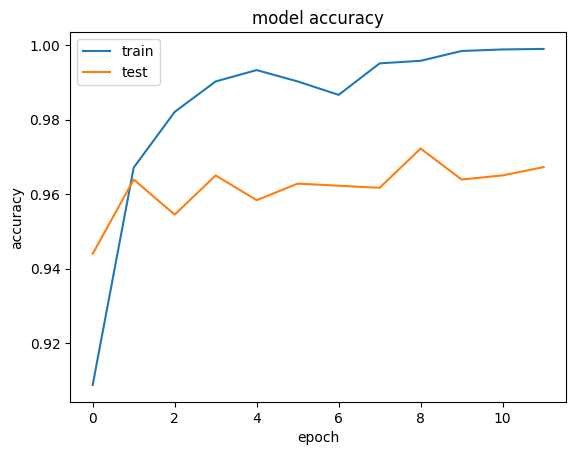

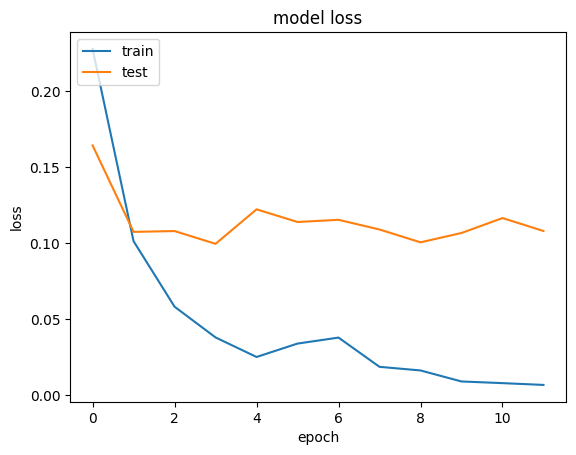

In [461]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Make predictions

In [462]:
ld_model = keras.models.load_model('/kaggle/working/model.h5')

In [357]:
ld_model.evaluate(ds[1])

57/57 [==============================] - 8s 134ms/step - loss: 0.1334 - accuracy: 0.9501


[0.13344937562942505, 0.9500831961631775]

In [463]:
import os

paths = []
names = []

for dirname, _, filenames in os.walk('/kaggle/input/datasaur-techosmotr/techosmotr/test'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        names.append(filename.replace(".jpeg",""))

In [464]:
predictions = []
for i in paths:
    img = (np.array(tf.keras.utils.load_img(
        i,
        grayscale=False,
        color_mode='rgb',
        target_size=(300, 400),
        interpolation='bilinear',
        keep_aspect_ratio=False))/255).reshape(-1, 300,400,3)

    predictions.append(round(ld_model.predict(img, verbose = 0)[0][0]))
    

In [466]:
# swapping 0s with 1s and 1s with 0s (Because tensorflow's tf.keras.utils.image_dataset_from_directory module swapped classes)
for i in range(len(predictions)):
    if predictions[i] == 0:
        predictions[i] = 1
    else:
        predictions[i] = 0

In [467]:
result = pd.DataFrame({'file_index': names, 'class': predictions})
result

,file_index,class
0,78942502,0
1,72473767,0
2,72306150,1
3,79367589,1
4,76954750,0
...,...,...
772,79797333,0
773,76019137,1
774,78672316,0
775,70007467,1


In [468]:
result.to_csv('/kaggle/working/result7.csv', index=False)

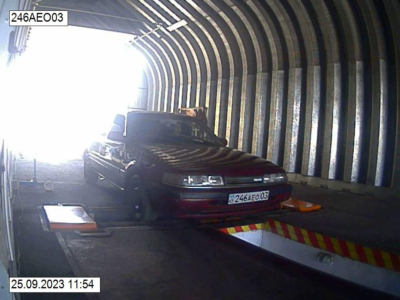

In [63]:
tf.keras.utils.load_img(
    '/kaggle/input/datasaur-techosmotr/case3-datasaur-photo/techosmotr/techosmotr/test/70076792.jpeg',
    grayscale=False,
    color_mode='rgb',
    target_size=(300, 400),
    interpolation='bilinear',
    keep_aspect_ratio=False)

,file_index,class
0,78942502,1
1,72473767,1
2,72306150,1
3,79367589,1
4,76954750,1
...,...,...
772,79797333,1
773,76019137,1
774,78672316,1
775,70007467,1


In [ ]:
dir_path = '/kaggle/input/datasaur-techosmotr/case3-datasaur-photo/techosmotr/techosmotr/test'
predictions = []
print()




for i in paths:
    
        predictions.
    


76395310
/kaggle/input/datasaur-techosmotr/case3-datasaur-photo/techosmotr/techosmotr/test/76395310.jpg


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/datasaur-techosmotr/case3-datasaur-photo/techosmotr/techosmotr/test/76395310.jpg'

In [ ]:


submission_df = pd.DataFrame({
    'id': test['id'],
    'result': preds
})